In [12]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from sippy import *
import plots

## <div align="center">Fractionator example</div>
<img src="frac.jpg">

**Reflux (FIC-2001)**
Increasing reflux (and keeping everything else constant) will decrease the Top Product (FIC-2101) and increase the bottoms product (FIC-2102) by the same amount.

**Mid Product (FIC-2002)**
Increasing the side draw FIC-2002 will affect FIC-2101 and FIC-2102. If we increase the side draw by 1 unit then both top and bottoms product will have to decrease by 1 unit.

**Feed Temperature (TIC-2003)**
Increasing the feed temperature also affects the mass balance in the fractionator and the feed is split in the top and bottoms product.

**Mid Reflux (FIC-2004)**
Increasing the mid reflux (FIC-2004) will also affect both top and bottoms product flow:

In [13]:
# Load spteptest data from a TSV file
file = r'..\data\FRAC2.csv'
columns = ['Time', 'AI-2020', 'AI-2021', 'AI-2022', 'FIC-2100', 'FIC-2101', 'FIC-2102', 'FI-2005', 'FIC-2001', 'FIC-2002', 'FIC-2004', 'QI-2106', 'TIC-2003']
step_test_data = pd.read_csv(file,index_col='Time', usecols=columns, parse_dates=True, skiprows=[1,2,3])
step_test_data.head()

,AI-2020,AI-2021,AI-2022,FIC-2100,FIC-2101,FIC-2102,FI-2005,FIC-2001,FIC-2002,FIC-2004,QI-2106,TIC-2003
Time,,,,,,,,,,,,
2015-10-01 08:14:00,2.00000,3.00000,4.00000,8.50000,2.10000,1.70000,5.02153,2.5,1.5,8.0,2.00000,200.0
2015-10-01 08:15:00,2.00360,3.00954,3.99831,8.50735,2.09686,1.71730,4.98768,2.5,1.5,8.0,1.99772,200.0
2015-10-01 08:16:00,2.00870,2.99518,3.97746,8.50977,2.09280,1.72500,4.93990,2.5,1.5,8.0,1.99552,200.0
2015-10-01 08:17:00,2.00385,3.01356,3.97262,8.50838,2.08587,1.71878,4.93333,2.5,1.5,8.0,1.99483,200.0
2015-10-01 08:18:00,1.99852,3.02963,3.98841,8.50365,2.08028,1.71360,4.96880,2.5,1.5,8.0,1.99465,200.0


In [14]:
#slice data for model identification case
start = '2015-10-02 05:14:00'
end = '2015-10-05 09:13:00'
idinput = step_test_data.loc[start:end].copy()

#Remove -9999
idinput = idinput.loc[(idinput >- 9999).any(1)]

#get time stamp for ploting
Time = idinput.index

#inspect dataframe
idinput.head()
# step_test.columns
# step_test.shape

,AI-2020,AI-2021,AI-2022,FIC-2100,FIC-2101,FIC-2102,FI-2005,FIC-2001,FIC-2002,FIC-2004,QI-2106,TIC-2003
Time,,,,,,,,,,,,
2015-10-02 05:14:00,1.79025,3.25618,4.31966,8.48585,2.09035,1.36061,5.78924,3.0,1.5,8.5,2.55616,200.0
2015-10-02 05:15:00,1.78843,3.26513,4.30975,8.48206,2.08341,1.36606,5.79211,3.0,1.5,8.5,2.55929,200.0
2015-10-02 05:16:00,1.79303,3.25387,4.30674,8.48012,2.09717,1.35851,5.76505,3.0,1.5,8.5,2.55834,200.0
2015-10-02 05:17:00,1.79985,3.24287,4.28263,8.47538,2.10629,1.36849,5.74577,3.0,1.5,8.5,2.55665,200.0
2015-10-02 05:18:00,1.80037,3.23815,4.27179,8.47844,2.11857,1.38291,5.74937,3.0,1.5,8.5,2.56038,200.0


In [15]:
#select Inputs and Outputs for the model identification case
#['AI-2020','AI-2021', 'AI-2022', 'FIC-2100', 'FIC-2101', 'FIC-2102', 'FI-2005', 'FIC-2001','FIC-2002', 'FIC-2004','QI-2106', 'TIC-2003']
inputs = ['FIC-2001','FIC-2002', 'TIC-2003', 'FIC-2004','FI-2005']
outputs = ['AI-2020','AI-2021', 'AI-2022']

In [16]:
# Create FIR filter to detrend signal 

ts = pd.Timedelta(step_test_data.index[1] - step_test_data.index[0]).total_seconds() # data sampling time
tss = 120
tss_sec = tss * 60
mult_factor = 3
filt_tss = tss_sec * mult_factor
cutoff = 1/2/filt_tss
pass_zero= 'lowpass'
nyq_rate = ts/2.0
width = 0.5/nyq_rate
ripple_db =65
N,beta =signal.kaiserord(ripple_db,width)
window = ('kaiser',beta)
coef = signal.firwin(numtaps=N, cutoff=cutoff, window=window, pass_zero=pass_zero, nyq = nyq_rate)
# plots.plot_freuency_response(coef)

In [17]:
# Detrend signal and plot
trend = signal.filtfilt(coef, 1.0,idinput, axis=0)
idinput = idinput - trend
# idinput.plot(subplots=True)
# plt.show()

In [18]:
# Convert dataframe to numpy array in the shape requied for SIPPY
u = idinput[inputs].to_numpy().T
y = idinput[outputs].to_numpy().T
print('Output shape:', y.shape)
print('Input shape:',u.shape)

Output shape: (3, 4560)
Input shape: (5, 4560)


In [19]:
#specify model identification parameters, reffer the documentation for detais.
model = 'frac2.npz' #model file name
method='CVA'
IC = 'AIC' # None, AIC, AICc, BIC
TH = 30 # The length of time horizon used for regression
fix_ordr = 25 # Used if and only if IC = 'None'
max_order = 25 # Used if IC = AIC, AICc or BIC
req_D = False
force_A_stable = False

In [20]:
sys_id = system_identification(
    y, 
    u, 
    method,
    SS_fixed_order=fix_ordr,
    SS_max_order=max_order,
    IC=IC,
    SS_f=TH,
    SS_p=TH,
    SS_D_required=req_D,
    SS_A_stability=force_A_stable
    )

#print model order
# print('Model order:', sys_id.n)

#save model parameters A, B, C,D and X0 as npz file
np.savez(model, A=sys_id.A, B=sys_id.B, C=sys_id.C, D=sys_id.D, K=sys_id.K, X0=sys_id.x0)

The suggested order is: n= 10


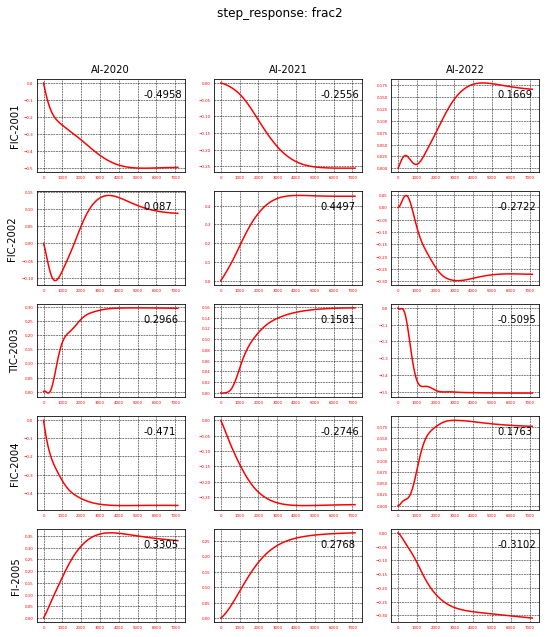

In [21]:
plots.plot_model(model, inputs, outputs, tss_sec, ts)

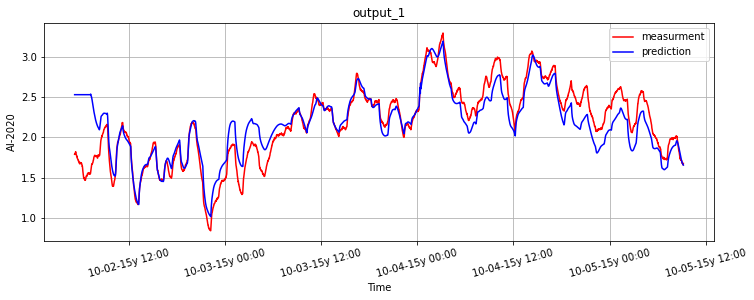

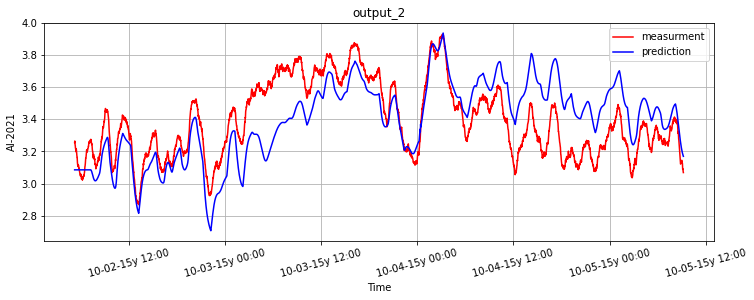

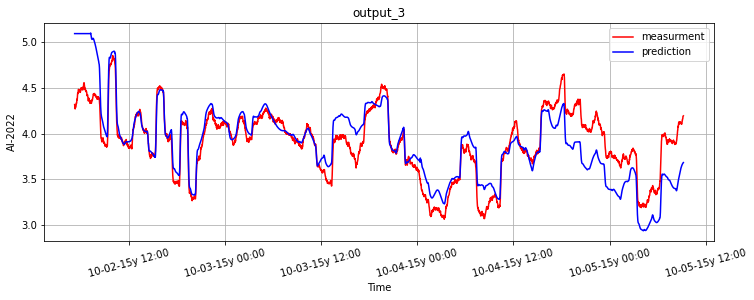

In [22]:
start_time = start
end_time = end
pad_len = int(tss_sec/ts)
plots.plot_comparison(step_test_data, model, pad_len, inputs, outputs, start_time, end_time, plt_input=False)